In [1]:
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F

random_seed = 1234
train_split_fraction = 0.7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
        transforms.RandomCrop(size=(32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_set = CIFAR10(
    './cifar10-train', 
    train=True, 
    download=True, 
    transform=train_transform,
    )

test_set = CIFAR10(
    './cifar10-test', 
    train=False, 
    download=True, 
    transform=test_transform,
    )

train_set_size = len(train_set)
indices = list(range(train_set_size))
np.random.shuffle(indices)
split = int(np.floor(train_split_fraction * train_set_size))
stored_patterns_idx, train_idx = indices[split:], indices[:split]

stored_patterns_sampler = SubsetRandomSampler(stored_patterns_idx)
train_sampler = SubsetRandomSampler(train_idx)

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=True, num_workers=4)
stored_patterns_loader = DataLoader(train_set, batch_size=split, sampler=stored_patterns_sampler)
stored_patterns = list(stored_patterns_loader)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def prepare_device(obj, use_cuda: bool = True):
    """Prepare device.
    Moves the passed object to the appropriate
    device."""
    if use_cuda and torch.cuda.is_available():
        return obj.to("cuda")
    return obj

In [3]:
import torch.nn as nn
import torch
from typing import List, Optional

class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        dropout: float = 0.0
    ):
        super(ConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.model = nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                self.out_channels,
                kernel_size=self.kernel_size,
                padding="same"
            ),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)


class MultiConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_sizes: List[int] = [3, 5, 7],
        channel_size: int = 32,
        dropput: float = 0.0
    ):
        super(MultiConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.channel_size = channel_size
        self.dropout = dropput
        self.blocks = nn.ModuleList()
        for k in self.kernel_sizes:
            self.blocks.append(
                nn.Sequential(
                    ConvBlock(self.in_channels, self.channel_size, kernel_size=k, dropout=self.dropout),
                    ConvBlock(self.channel_size, self.out_channels, kernel_size=k, dropout=self.dropout),
                    nn.BatchNorm2d(self.out_channels)
                )
            )

    def forward(self, x):
        res = None
        for b in self.blocks:
            y = b(x)
            if res is None:
                res = y
            else:
                res = res + y

        return res

class MultiConvBlockConcat(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_sizes: List[int] = [3, 5, 7],
        channel_size: int = 32,
        flat_size: int = 1024
    ):
        super(MultiConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.channel_size = channel_size
        self.flat_size = flat_size
        self.blocks = nn.ModuleList()
        for k in self.kernel_sizes:
            self.blocks.append(
                nn.Sequential(
                    ConvBlock(self.in_channels, self.channel_size, kernel_size=k),
                    ConvBlock(self.channel_size, self.out_channels, kernel_size=k),
                    nn.BatchNorm2d(self.out_channels)
                )
            )

    def forward(self, x):
        res = None
        for b in self.blocks:
            y = b(x)
            if res is None:
                res = y.reshape(-1, self.flat_size)
            else:
                res = torch.cat(tensors=[res, y.reshape(-1, 784)], dim=1)
        return res


class CNetwork(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        emb_dim: int,
        flat_size: int = 1024,
        dropout: float = 0.0
        ):
        super(CNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_dim = emb_dim
        self.flat_size = flat_size
        self.dropout = dropout

        self.b1 = MultiConvBlock(in_channels=self.in_channels, out_channels=16, dropput=self.dropout)
        self.b2 = MultiConvBlock(in_channels=16, out_channels=16, dropput=self.dropout)
        self.b3 = MultiConvBlock(in_channels=16, out_channels=16, dropput=self.dropout)
        self.b4 = MultiConvBlock(in_channels=16, out_channels=self.out_channels, dropput=self.dropout)
        
        self.fc = nn.Sequential(
            MultiConvBlock(in_channels=self.out_channels * self.in_channels, out_channels=self.out_channels, dropput=self.dropout),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.emb_dim)
        )
        # self.fc = nn.Linear(self.flat_size * self.in_channels, self.emb_dim)

    def forward(self, x):
        b1o = self.b1(x)
        b2o = self.b2(b1o)
        b3o = self.b3(b2o) + b1o
        b4o = self.b4(b3o) + x
        # z = b4o.reshape(-1, self.flat_size * self.in_channels)
        # return self.fc(z)
        return self.fc(b4o)

class WNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, dropout: Optional[float]):
        super(WNetwork, self).__init__()
        self.dropout = dropout
        self.layers = []
        self.layers.append(nn.Linear(in_dim, out_dim))
        self.layers.append(nn.ReLU(inplace=True))
        if self.dropout is not None:
            self.layers.append(nn.Dropout(self.dropout))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

class HopfieldNet(nn.Module):
    def __init__(
        self,
        classes: int,
        in_channels: int,
        hidden_store_dim: int, 
        dropout_ratio: float = 0.3):
        super().__init__()
        
        self.classes = classes
        self.in_channels = in_channels
        self.hidden_store_dim = hidden_store_dim
        self.dropout_ratio = dropout_ratio
        self.device = device
        self.__q = None
        self.WK = None
        self.WQ = None

        self.__init_parameters()
    
    def __init_parameters(self):
        # stored patterns
        self.WQ = WNetwork(
            self.classes,
            self.hidden_store_dim,
            self.dropout_ratio
        )

        self.WK = CNetwork(
            in_channels=self.in_channels,
            out_channels=1,
            emb_dim=self.hidden_store_dim,
            dropout=self.dropout_ratio
        )

        self.__q = torch.eye(self.classes)

    def to(self, device: str):
        super().to(device)
        self.WQ = self.WQ.to(device)
        self.WK = self.WK.to(device)
        self.q = self.__q.to(device)
        return self


    def forward(self, stored_patterns, beta=1.0):
        Q = self.WQ(self.__q.to(self.device))
        Q = Q / torch.norm(Q, dim=1, keepdim=True)

        # W_K^TY^T
        K = self.WK(stored_patterns)
        # Normalize inputs to make it work
        K = K / torch.norm(K, dim=1, keepdim=True)

        # Log softmax because we later use CrossEntropyLoss
        # which expects logits because it will apply a softmax
        # internally. (Pytorch thing)    
        Z = torch.log_softmax(beta * Q @ K.T, dim=1)
        
        return Z 

In [4]:
from torchinfo import summary as torch_summary

model = HopfieldNet(
    classes=10,
    in_channels=3,
    hidden_store_dim=64, 
    dropout_ratio=0.2)
model = prepare_device(model)
num_params = sum([p.numel() for p in model.parameters()])
print(f"Total number of parameters in model (W params + bias): {num_params}")
print(torch_summary(model))
print(model)

Total number of parameters in model (W params + bias): 556706
Layer (type:depth-idx)                                  Param #
HopfieldNet                                             --
├─WNetwork: 1-1                                         --
│    └─Sequential: 2-1                                  --
│    │    └─Linear: 3-1                                 704
│    │    └─ReLU: 3-2                                   --
│    │    └─Dropout: 3-3                                --
├─CNetwork: 1-2                                         --
│    └─MultiConvBlock: 2-2                              --
│    │    └─ModuleList: 3-4                             50,704
│    └─MultiConvBlock: 2-3                              --
│    │    └─ModuleList: 3-5                             85,232
│    └─MultiConvBlock: 2-4                              --
│    │    └─ModuleList: 3-6                             85,232
│    └─MultiConvBlock: 2-5                              --
│    │    └─ModuleList: 3-7        

In [5]:
sim_raw_stored = torch.randn((200, 3, 32, 32)).to(device)
result = model(sim_raw_stored)
print(f"Shape of Result: {result.T.shape}")
assert list(result.T.shape) == [200, 10], "Result shape doesn't match with the expected result"

Shape of Result: torch.Size([200, 10])


In [6]:
import torch.optim as optim
import torchmetrics

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-3)
metric = torchmetrics.Accuracy()

In [7]:
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

class Context:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def train_step(
    ctx: Context,
    loss_fn, 
    optimizer):
    """Train step.
    Traverses the dataloader once
    and performs updates on each
    bach."""
    total_loss = 0
    total_batches = 0
    for R, y in ctx.dataloader:
        total_batches += 1
        batch = prepare_device(R)
        y = prepare_device(y)

        optimizer.zero_grad()
        pred = model(batch, beta=ctx.beta)
        loss = loss_fn(pred.T, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
        log_gradients(ctx.logger, model, ctx.step)

    total_size = len(ctx.dataloader.dataset)
    return total_loss / total_size


def evaluate(
    ctx,
    metric_fn):
    """Evaluate.
    Calculates the metric on the provided 
    dataloader"""
    model.eval()
    with torch.no_grad():
        for R, y in ctx.dataloader:
            batch = prepare_device(R)
            y = prepare_device(y)
            
            preds = model(batch, beta=ctx.beta).to("cpu")
            metric = metric_fn(preds.T, y.to("cpu"))
        metric = metric_fn.compute()
        metric_fn.reset()
    return metric


def log_summary(logger: SummaryWriter, loss, metric, step):
    logger.add_scalar('loss', loss, global_step=step)
    logger.add_scalar('accuracy', metric, global_step=step)
    logger.flush()


def log_gradients(logger: SummaryWriter, model, step):
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        else:
            logger.add_histogram(
                tag=f'grads/{name}', 
                values=p.grad.data.detach().cpu().numpy(),
                global_step=step
            )
    logger.flush()
    

def train(
    epochs, 
    dataloader, 
    model,
    loss_fn, 
    optimizer, 
    metric_fn,
    beta,
    logger: SummaryWriter):

    ctx = Context(
        dataloader=dataloader,
        model=model,
        beta=beta,
        logger=logger,
        step=0
    )

    model.train()
    with tqdm(total=epochs) as progress:
        for i in range(epochs):
            ctx.step = i
            loss = train_step(
                ctx,
                loss_fn, 
                optimizer)
            metric = evaluate(
                ctx,
                metric_fn)

            log_summary(logger, loss, metric, i)

            progress.set_postfix({
                        "loss": f"{loss:.4f}",
                        "accuracy": f"{metric:.2f}"
                    })
            progress.update()

        

In [8]:
!rm -rf tensorboard

In [9]:

%%time
from torch.utils.tensorboard import SummaryWriter

# beta = 1 / np.sqrt(store_dim) # beta as classic transformers - less performance
beta = 4.0
with SummaryWriter(log_dir='./tensorboard') as tb_writer:
    train(400, train_loader, model, loss_fn, optimizer, metric, beta, tb_writer)


100%|█████████████████████████████████████████████████████████████████████| 400/400 [2:41:01<00:00, 24.15s/it, loss=0.0002, accuracy=0.90]

CPU times: user 5d 11h 34min 51s, sys: 3h 2min 18s, total: 5d 14h 37min 9s
Wall time: 2h 41min 1s


In [10]:
beta = 4.0
model.eval()
with torch.no_grad():
    for R, y in test_loader:
        batch = prepare_device(R)
        preds = model(batch, beta=beta).to("cpu")
        m = metric(preds.T, y)
    m = metric.compute()
    metric.reset()
    print(f"Test Accuracy: {m:.4%}")

Test Accuracy: 81.5900%


In [11]:
import matplotlib.pyplot as plt

def plot_images(batch, preds, trues, rows=4, cols=4):
    images = batch[:rows * cols]
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    fig, ax = plt.subplots(rows, cols, figsize=(10, 6))
    fig.set_facecolor('white')
    axes = ax.ravel()
    fig.suptitle("Model Predictions")
    for idx in range(len(images)):
        y_hat = preds[idx]
        y = trues[idx]
        axes[idx].set_title(f"$\hat{{y}}={y_hat}$, $y={y}$")
        axes[idx].imshow(np.transpose(images[idx], [1, 2, 0]))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    plt.tight_layout()
    plt.show()

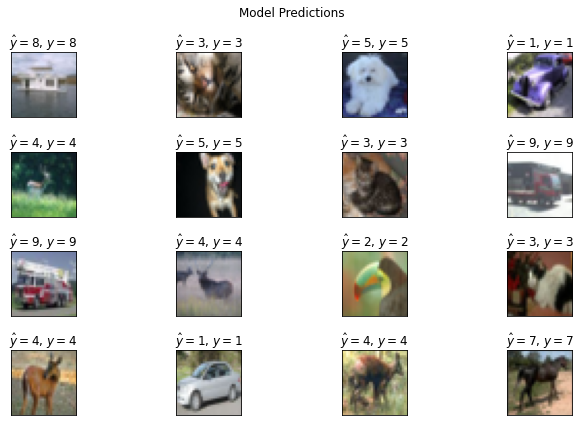

In [12]:
examples = np.random.randint(0, len(test_set), size=16)
batch = torch.stack([test_set[i][0] for i in examples])
y = np.array([test_set[i][1] for i in examples])

with torch.no_grad():
    y_hat = model(prepare_device(batch), beta=beta)
    y_hat = torch.argmax(y_hat.T, dim=1).cpu().numpy()

plot_images(batch.cpu().numpy(), y_hat, y)

In [13]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}